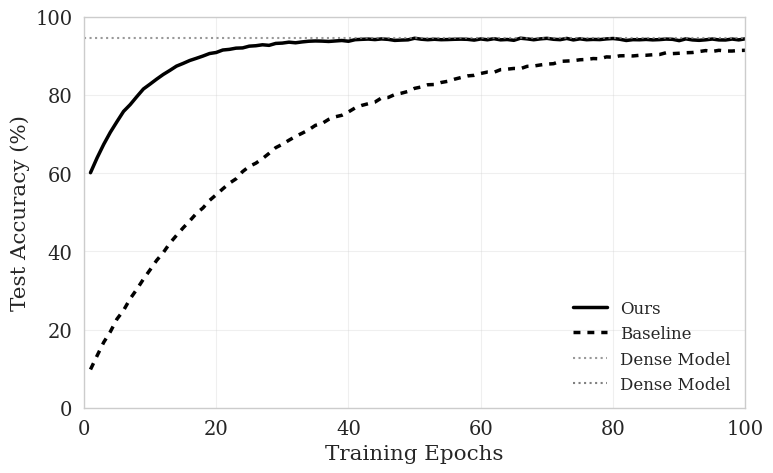

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 基础设置：使用 seaborn 的 "paper" 风格，字体设为衬线体
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.4

# --- A. 数据模拟函数 ---
def generate_curve(epochs, start, end, rate, noise=0.1):
    x = np.linspace(0, epochs, epochs)
    # 指数逼近公式
    y = end - (end - start) * np.exp(-rate * x)
    # 添加少量噪声
    y += np.random.normal(0, noise, epochs)
    return y

# --- B. 定义稀疏度和实验参数 ---
EPOCHS = 100
DENSE_ACC = 94.5
# 定义你要对比的几个稀疏度
sparsity_levels = [0.5, 0.7, 0.9]  # 50%, 70%, 90% 稀疏度

data_list = []
epochs_range = np.arange(1, EPOCHS + 1)

# --- C. 生成数据循环 ---
for sp in sparsity_levels:
    # 模拟逻辑：稀疏度越高(0.9)，最终精度越低，且 Baseline 掉得越厉害
    # Ours: 
    #   - Start: 随稀疏度增加略微降低，但依然是非0 (Warm Start)
    #   - End: 随稀疏度增加略微降低
    ours_start = 60.0 - (sp * 10)  # 50%->55, 90%->51
    ours_end = DENSE_ACC - (sp * 1.5) # 接近 Dense
    
    # Baseline:
    #   - Start: 很低 (Standard Pruning)
    #   - End: 比 Ours 低
    base_start = 10.0
    base_end = DENSE_ACC - (sp * 4.0) # 差距拉大

    # 生成曲线
    acc_ours = generate_curve(EPOCHS, ours_start, ours_end, rate=0.12)
    acc_base = generate_curve(EPOCHS, base_start, base_end, rate=0.05)
    
    # 存入列表
    # 注意：这里把 Sparsity 格式化为字符串，方便图例显示
    sp_label = f"{int(sp*100)}% Sparsity"
    
    df_o = pd.DataFrame({'Epoch': epochs_range, 'Accuracy': acc_ours, 'Method': 'Ours', 'Sparsity': sp_label})
    df_b = pd.DataFrame({'Epoch': epochs_range, 'Accuracy': acc_base, 'Method': 'Baseline', 'Sparsity': sp_label})
    data_list.extend([df_o, df_b])

# 合并数据
data = pd.concat(data_list)

# --- D. 绘图核心 ---
plt.figure(figsize=(8, 6))

# 1. 配色方案：使用渐变色 (Sequential Palette)
# "Blues" 或 "Greens" 或 "Reds"。这里用蓝色系，颜色越深代表稀疏度越高，符合直觉。
palette_name = "Blues" 
# 注意：as_cmap=False 确保返回离散颜色列表
# 我们取 palette 中偏深的几个颜色，避免太浅看不清
colors = sns.color_palette(palette_name, n_colors=len(sparsity_levels) + 2)[2:] 

# 2. 画主曲线
# hue=Sparsity: 不同稀疏度用不同深浅的颜色
# style=Method: Ours用实线，Baseline用虚线
ax = sns.lineplot(
    data=data, 
    x="Epoch", 
    y="Accuracy", 
    hue="Sparsity", 
    style="Method",
    palette=colors,
    markers=False,
    dashes={'Ours': '', 'Baseline': (2, 2)}, # 实线 vs 虚线
    linewidth=2.5
)

# 3. 画 Dense Model (背景参考线)
plt.axhline(y=DENSE_ACC, color='black', linestyle=':', linewidth=1.5, alpha=0.6, label='Dense Model')

# --- E. 极简修饰 ---
plt.title("Convergence at Different Sparsity Levels", fontsize=14, fontweight='bold', pad=15)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.xlabel("Training Epochs", fontsize=12)
plt.xlim(0, EPOCHS)
# Y轴范围可以根据数据调整，例如只展示后期收敛部分 (zoom in) 效果更好
plt.ylim(40, 96) 

# --- F. 图例优化 (Legend) ---
# 默认的 seaborn 图例会把 hue 和 style 分开，比较占地。
# 这里我们只保留颜色（代表稀疏度）的图例，然后在标题或文中说明实线/虚线含义即可，或者保留全部但排版整齐。
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)

plt.tight_layout()
plt.show()
# plt.savefig("sparsity_convergence.pdf", bbox_inches='tight')